# Prepara AMVA

Script diseñado para preparar la cuenca del AMVA para la simulación de cuadales, esta cuenca se encuentra trazada a la altura de aula ambiental.

El siguiente script puede preparar la cuenca en su versión de **celdas**, para ver la versión de laderas lo hace el script **Prepara_AMVA_hills.ipynb**

## Cargado de paquetes y lectura de mapas DEM y DIR

In [1]:
%matplotlib inline
from wmf import wmf 
import numpy as np
import pylab as pl

In [2]:
ruta_demdir = '../raster/'
ruta_saveBasin = 'cuencaBinarios/'
ruta_loadBasin = 'cuencaBinarios/'

In [3]:
DEM=wmf.read_map_raster(ruta_demdir+'dem_corr.tif',True)
DIR=wmf.read_map_raster(ruta_demdir+'dir2.tif',True)
wmf.cu.nodata=-9999.0; wmf.cu.dxp=30.0
DIR[DIR<=0]=wmf.cu.nodata.astype(int)
DIR=wmf.cu.dir_reclass(DIR,wmf.cu.ncols,wmf.cu.nrows)

## Trazado de la cuenca 

A continuación se traza el cauce y luego la cuenca del AMVA a la altura de Aula Ambiental.

Luego se guardan los .shp de la red hídrica y de la cuenca, también del cauce utilizado para su trazado.

La línea para guardar el binario de la cuenca se encuentra comentada, ya que esta ya ha sido guardada y luego cuando se tengan todos los parámetros será guardada de nuevo.

In [4]:
# una corriente que pase cerca 
St = wmf.Stream(-75.618,6.1248,DEM=DEM,DIR=DIR,name ='Rio Medellin')
St.Save_Stream2Map('../../vectores/RioMedellin.shp')
# Trazado de la cuenca 
cuAMVA = wmf.SimuBasin(-75.57250,6.2641, DEM, DIR, name='amva',
    dt = 300, stream = St)
#Guardado del shp de la cuenca 
cuAMVA.Save_Basin2Map('../../vectores/Cuenca_AulaAmbiental.shp')
cuAMVA.Save_Net2Map('../../vectores/RedHidrica_Aula.shp')

Parámetros geomorfológicos 
- como se trata de un modelo tipo celda, el ancho en el canal para cada celda es igual al largo de la celda.

In [5]:
cuAMVA.GetGeo_Cell_Basics()
cuAMVA.set_Geomorphology(stream_width=cuAMVA.CellLong)

___
## Parámetros Físicos

### Preparación parámetros verticales 

- Velocidades Verticales:
    - Tanque 1 a exterior (evaporacion): controlado por $EVP$, en el modelo se representa como **vspeed(1,:) = v_coef(1,:)R[1]dt**
    - Tanque 1 a Tanque 2 (Sat del capilar): controlado por $H_u$ y por la precipitación $P_{t}$.
    - Tanque 2 a Tanque 3 (infiltracion): controlado por $k_s$, el cual en el modelo se representa mediante **vspeed(2,:) = v_coef(2,:)R[2]dt**
    - Tanque 3 a Tanque 4 (percolación): controlado por $k_p$ el cual en el modelo se representa mediante **vspeed(3,:) = v_coef(3,:)R[3]dt**
    - Tanque 4 a Perdidas (perdidas); controlado por $k_{pp}$ en el modelo se presenta como **vspeed(4,:) = v_coef(4,:)R[4]dt**


- **EVP**: se asume según la ecuación de Turc a escala diaria y se divide por el tamano de $\delta t$, en este caso para $\delta t = 10min$, el coeficiente de conversión es 144.
- **ks**: El valor de toma del mapa:
```
    /home/nicolas/Dropbox/SIATA/simulacion/raster/Ks_mmh.asc.
```
- **kp**: se asume igual a la unidad y se calibra.
- **kpp**: se asume igual a cero.

In [6]:
# Evaporación en la cuenca estimada por Budyko
Evp=4.658*np.exp(-0.0002*cuAMVA.CellHeight)/144.0
# Cionductividad hidraulica saturada 
Ks, p = wmf.read_map_raster(ruta_demdir+'Ks_mmh.asc')
Ks = cuAMVA.Transform_Map2Basin(Ks,p)/3600.0

In [7]:
cuAMVA.set_PhysicVariables('v_coef',Ks,1)
cuAMVA.set_PhysicVariables('v_coef',Evp,0)
cuAMVA.set_PhysicVariables('v_coef',0,3)

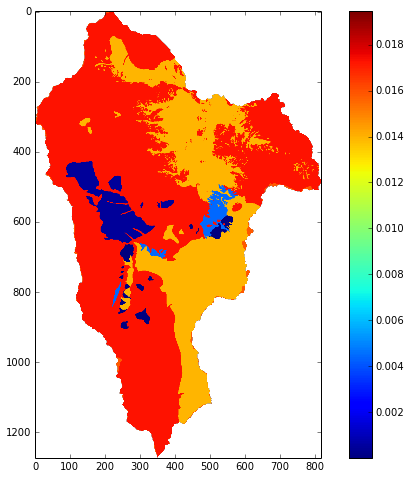

In [8]:
cuAMVA.Plot_basin_fast(wmf.models.v_coef[1])

### Prepración de parámetros horizontales

A continuación se preparan los parámetros para el flujo horizontal de agua en la cuenca.

- Velocidades Horizontales:
    - Salida Tanque 2: Se representa como $v_2$ y en el modelo esta atada a: **hspeed(1,:) = h_coef(1,:)R[5]** en el caso lineal, y en el no lineal se involucra el termino **h_exp(1,:)**
    - Salida Tanque 3: Se representa como $k_{sh}$ o $v_{3}$ en el modelo se muestra commo: **hspeed(2,:) = h_coef(2,:)R[6]**, enn el caso no lineal el termino **h_exp(2,:)** entra.
    - Salida Tanque 4: Se representa como $k_{ph}$ o $v_{4}$ en el modelo se muestra commo: **hspeed(3,:) = h_coef(3,:)R[7]**, en el caso no lineal el término **h_exp(3,:)** se tiene en cuenta.
    - Salida Tanque 5: Se representa como $v_{5}$, el modelo esta atado a **h_coef(4,:)** y a **h_exp(4,:)**, siempre es no lineal, en calibración el parámetro **R[8]** es el responsable.
    
>- **Velocidad en ladera**: $v_2 = \frac{1}{n}R_{h} ^{2/3}S_{0}^{1/2}$
en el caso de una sección rectangular $R_h = \frac{by}{b+2y}$, asumiendo un valor de $b = 30$ y una profundidad $y = 0.08$, se tiene la siguiente ecuación $v_2 = \frac{1}{n} 0.08^{2/3} S_0^{1/2} F_c$ donde $F_c = 0.08$ es un factor corrector para asignar una magnitud a $v_2$ que sea coherente.

In [9]:
#Lee el mapa de rugosidad en las laderas
n,p = wmf.read_map_raster(ruta_demdir+'n_man.asc')
n = cuAMVA.Transform_Map2Basin(n,p)

In [10]:
#Obtiene la velocidad sobre las laderas 
v2 = (1.0/n)*0.08**(0.66)*cuAMVA.CellSlope**(0.5)*0.08
print v2.mean()

0.223068


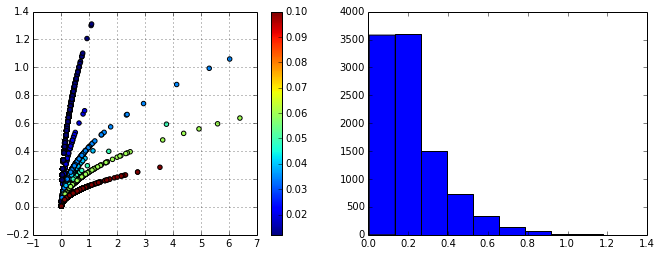

In [11]:
#figura de la velocidad Vs la pendiente e histograma de velocidades 
pos = np.random.choice(cuAMVA.ncells,10000)
fig = pl.figure(figsize=(11,4))
ax = fig.add_subplot(121)
a = pl.scatter(cuAMVA.CellSlope[pos],v2[pos],c=n[pos])
a = pl.colorbar()
pl.grid()
ax = fig.add_subplot(122)
a = pl.hist(v2[pos])

In [12]:
#Velocidades en los tanques 3 y 4
v3 = Ks * cuAMVA.CellSlope**0.5
v4 = Ks *0.1* cuAMVA.CellSlope**0.5
Lista=[v2,v3,v4]

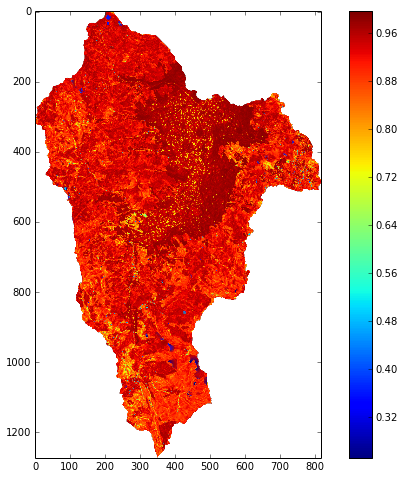

Tasa transferencia Media [%]: 0.920581


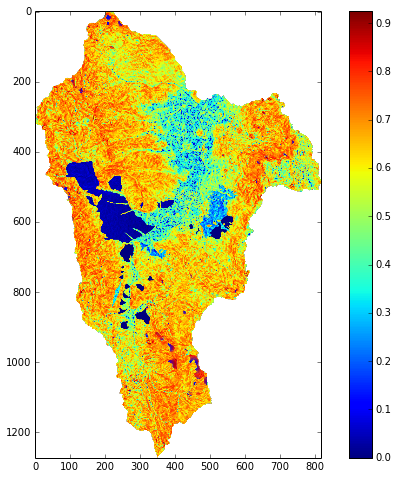

Tasa transferencia Media [%]: 0.566186


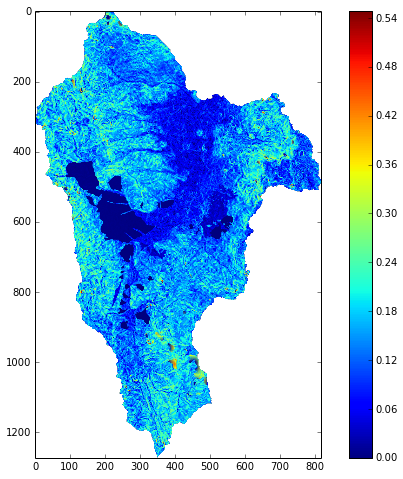

Tasa transferencia Media [%]: 0.137166


In [13]:
#Si uno calcula los coeficientes lineales de salida de cada tanque
calib = [10, 25, 25]
hflux=[]
for c,v in zip(calib,Lista):
    hflux.append(1.0 - (wmf.models.hill_long/(c*v*wmf.models.dt 
        + wmf.models.hill_long)) )
for h in hflux:
    cuAMVA.Plot_basin_fast(h)
    print 'Tasa transferencia Media [%]: ' + str(h.mean())

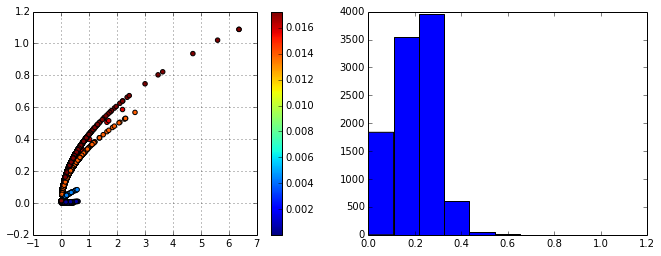

In [14]:
#distribución de las velocidades sub-superficiales
pos = np.random.choice(cuAMVA.ncells,10000)
fig = pl.figure(figsize=(11,4))
ax = fig.add_subplot(121)
a = pl.scatter(cuAMVA.CellSlope[pos],v3[pos]*calib[1],c=Ks[pos])
a = pl.colorbar()
pl.grid()
ax = fig.add_subplot(122)
a = pl.hist(v3[pos]*calib[1])

In [15]:
#Asigna los parametros a la cuenca 
for pos,var in enumerate(Lista):
    cuAMVA.set_PhysicVariables('h_coef',var,pos)

### Preparación parámetros de almacenamiento 

A continuación se prepara el almacenamiento máximo capilar y el almacenamiento máximo del suelo. 

- **Capilar**: se ha calculado en función de la profundidad reticular y del tipo de suelo.
- **Gravitacional**: se calcula en función de la profundidad del suelo y del tipo de suelo.

#### Almacenamiento capilar 

Se calculó de acuerdo a lo presentado por Montoya, 2008

In [16]:
# almacenamiento gravitacional 
Hu,p = wmf.read_map_raster(ruta_demdir+'Hu_mm.asc')
Hu = cuAMVA.Transform_Map2Basin(Hu,p)

#### Almacenamiento gravitacional 

El almacenamiento en el suelo se va a estimar como la profundidad de la capa de suelo multiplicada por un valor constante de porcentaje de volúmen de vacios y a este resultado se le resta el almacenamiento capilar, debido a que este ya se tiene en cuenta en el almacenamiento capilar.

La ecuación que lo explica es la siguiente:

$H_3 = Z n - H_u$, donde $n$ es el porcentaje de vacios y $Z$ la profundidad 

In [17]:
#Lectura del mapa de profundidades
ProfSuelo,p = wmf.read_map_raster('../../deslizamientos/raster/ProfSimCorr.tif')
ProfSuelo = cuAMVA.Transform_Map2Basin(ProfSuelo,p)
ProfSuelo[ProfSuelo<0]=0
#Calculo del almacenamiento maximo 
H3 = ProfSuelo*200-Hu
H3[H3<0] = 0

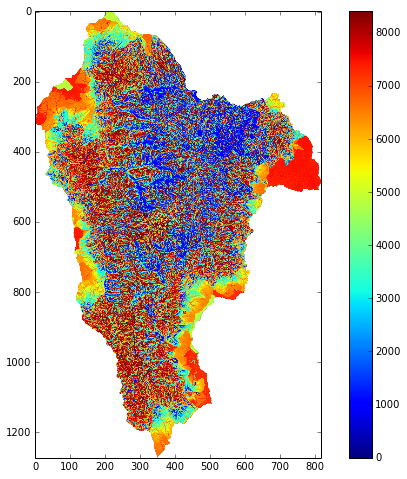

2594.33305028


In [27]:
cuAMVA.Plot_basin_fast(H3)
print H3.mean()*cuAMVA.ncells/1e6

In [18]:
# Asigna las variables de almacenamiento a la cuenca 
cuAMVA.set_PhysicVariables('capilar',Hu,0)
cuAMVA.set_PhysicVariables('gravit',H3,1)

___
## Guarda la cuenca en un binario 

A continuación se guarda la cuenca en un binario localizado en:

```
/home/nicolas/Dropbox/SIATA/simulacion/scripts2/cuencaBinarios/cuencaAMVA_v1.nc
```

In [19]:
ruta_abs = '/home/nicolas/Dropbox/SIATA/simulacion/raster/'

In [20]:

cuAMVA.save_SimuBasin('cuencaBinarios/cuencaAMVA_v1.nc',
    ruta_dem = ruta_abs+'dem_corr.tif',
    ruta_dir = ruta_abs+'dir2.tif')